Implementazione di https://medium.com/eni-digitalks/a-simple-recommender-system-using-pagerank-4a63071c8cbf

Da: https://grouplens.org/datasets/movielens/ scaricare [ml-latest-small.zip](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

## recommended for education and development
 
### MovieLens Latest Datasets

These datasets will change over time, and are not appropriate for reporting research results. We will keep the download links stable for automated downloads. We will not archive or make available previously released versions.

_Small_: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018.

    README.html
[ml-latest-small.zip](https://files.grouplens.org/datasets/movielens/ml-latest-small.zip) (size: 1 MB)

_Full_: approximately 33,000,000 ratings and 2,000,000 tag applications applied to 86,000 movies by 330,975 users. Includes tag genome data with 14 million relevance scores across 1,100 tags. Last updated 9/2018.

    README.html
[ml-latest.zip](https://files.grouplens.org/datasets/movielens/ml-latest.zip) (size: 335 MB) 

Permalink: https://grouplens.org/datasets/movielens/latest/

In [1]:
import pandas as pd

# Open ratings.csv file
ratings = pd.read_csv("../ml-latest-small/ratings.csv")

In [2]:
# Open movies.csv file
movies = pd.read_csv("../ml-latest-small/movies.csv")

In [3]:
# Merge ratings and movies
user_movie_matrix = pd.merge(ratings, movies, on="movieId", how="inner")

In [4]:
user_movie_matrix.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [5]:
# print out the unique values of the rating column
print(user_movie_matrix["rating"].unique())

[4.  4.5 2.5 3.5 3.  5.  0.5 2.  1.5 1. ]


In [5]:
# Map rating to scores

mapping_score = {
    0.5:-1.2,
    1:-1.1,
    1.5:-1,
    2:-0.5,
    2.5:-0.1,
    3:0.1,
    3.5:0.5,
    4:1,
    4.5:1.1,
    5:1.2
}

Basandoci sulle ratings presenti nel dataset vado a proiettare il grafo movie_movie che mi consente di trovare la similarità tra i film. Il vettore di mappaggio è scelto arbitrariamente e serve a decidere quanto pesano le varie ratings.

In [6]:
import networkx as nx

# Create a directed graph
user_movie_graph = nx.Graph()

# Add nodes and edges
for _, row in user_movie_matrix.iterrows():
    user_movie_graph.add_node(row["userId"], bipartite=0)
    user_movie_graph.add_node(row["title"], bipartite=1, genre=row["genres"], movieId=row["movieId"])
    # user_movie_graph.add_edge(row["userId"], row["title"], weight=row["rating"])
    user_movie_graph.add_edge(row["userId"], row["title"], weight=mapping_score[row["rating"]])
# 4s

In [8]:
# Debug print to check the graph construction
print(f"Nodes in the graph: {list(user_movie_graph.nodes(data=True))[:10]}")
print(f"Edges in the graph: {list(user_movie_graph.edges(data=True))[:10]}")

Nodes in the graph: [(1, {'bipartite': 0}), ('Toy Story (1995)', {'bipartite': 1, 'genre': 'Adventure|Animation|Children|Comedy|Fantasy', 'movieId': 1}), (5, {'bipartite': 0}), (7, {'bipartite': 0}), (15, {'bipartite': 0}), (17, {'bipartite': 0}), (18, {'bipartite': 0}), (19, {'bipartite': 0}), (21, {'bipartite': 0}), (27, {'bipartite': 0})]
Edges in the graph: [(1, 'Toy Story (1995)', {'weight': 1}), (1, 'Grumpier Old Men (1995)', {'weight': 1}), (1, 'Heat (1995)', {'weight': 1}), (1, 'Seven (a.k.a. Se7en) (1995)', {'weight': 1.2}), (1, 'Usual Suspects, The (1995)', {'weight': 1.2}), (1, 'From Dusk Till Dawn (1996)', {'weight': 0.1}), (1, 'Bottle Rocket (1996)', {'weight': 1.2}), (1, 'Braveheart (1995)', {'weight': 1}), (1, 'Rob Roy (1995)', {'weight': 1.2}), (1, 'Canadian Bacon (1995)', {'weight': 1.2})]


In [ ]:
import sys

edge_mem = sum([sys.getsizeof(e) for e in user_movie_graph.edges])
node_mem = sum([sys.getsizeof(n) for n in user_movie_graph.nodes])

print("Edge memory:", edge_mem / (1024**2),"MB")
print("Node memory:", node_mem / (1024**2),"MB")
print("Total memory:", (edge_mem + node_mem) / (1024**2), "MB")

Edge memory MB: 5.385009765625
Node memory MB: 0.7169580459594727
Total memory MB: 6.101967811584473


In [11]:
users = {n for n, d in user_movie_graph.nodes(data=True) if d["bipartite"] == 0}
print(f"Users: {list(users)[:10]}")
print(f"Number of users: {len(users)}")

Users: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Number of users: 610


In [7]:
movies = {n for n, d in user_movie_graph.nodes(data=True) if d["bipartite"] == 1}
print(f"Movies: {list(movies)[:10]}")
print(f"Number of movies: {len(movies)}")

Movies: ['Saving Mr. Banks (2013)', 'Front Page, The (1974)', 'Men of Honor (2000)', 'Critical Care (1997)', 'Undead (2003)', 'Mary of Scotland (1936)', 'The Intern (2015)', 'The Greatest Showman (2017)', 'Dear Zachary: A Letter to a Son About His Father (2008)', 'Humpday (2009)']
Number of movies: 9719


In [13]:
print(nx.is_bipartite(user_movie_graph))
print(nx.is_connected(user_movie_graph))

True
True


In [8]:
# Project the graph using weights
movie_movie_graph = nx.bipartite.weighted_projected_graph(user_movie_graph, movies)
# 1m 20s

In [9]:
dct = {}
for e in movie_movie_graph.edges(data=True):
    if e[2]['weight'] not in dct:
        dct[e[2]['weight']] = 1
    else:
        dct[e[2]['weight']] += 1

{1: 8415931, 2: 2044504, 3: 906219, 5: 307549, 4: 493971, 6: 208104, 8: 110703, 7: 148657, 9: 84516, 13: 35679, 10: 66542, 11: 52977, 12: 43540, 15: 24970, 14: 29925, 22: 8931, 16: 21227, 21: 10149, 19: 13299, 17: 17823, 23: 7871, 18: 15317, 20: 11565, 29: 3975, 27: 4820, 24: 6977, 25: 6255, 26: 5437, 55: 410, 63: 265, 28: 4319, 46: 814, 42: 1108, 37: 1726, 60: 328, 45: 883, 59: 315, 35: 2136, 41: 1214, 31: 3216, 50: 619, 30: 3572, 52: 560, 65: 222, 51: 585, 62: 271, 47: 763, 44: 983, 69: 170, 56: 397, 33: 2564, 58: 328, 49: 649, 48: 669, 67: 234, 36: 1899, 32: 2884, 64: 210, 40: 1355, 43: 1027, 57: 359, 34: 2370, 38: 1622, 54: 456, 53: 494, 103: 21, 71: 164, 97: 44, 72: 121, 95: 43, 61: 290, 82: 84, 88: 50, 102: 26, 92: 45, 84: 83, 81: 85, 39: 1471, 111: 13, 99: 34, 70: 172, 91: 46, 78: 103, 85: 76, 66: 194, 74: 150, 75: 125, 89: 49, 77: 114, 73: 133, 104: 22, 117: 13, 135: 8, 96: 44, 83: 81, 136: 5, 76: 114, 151: 3, 86: 56, 93: 46, 167: 2, 119: 14, 113: 14, 133: 3, 162: 3, 108: 25, 1

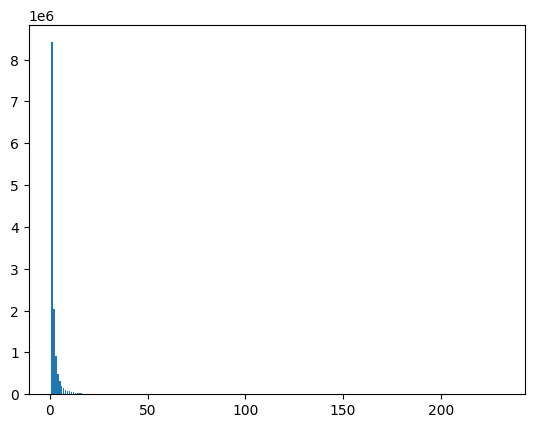

In [13]:
print(dct)
# bar plot of the dict

import matplotlib.pyplot as plt
plt.bar(dct.keys(), dct.values())
plt.show()

In [ ]:
print(len(movie_movie_graph.nodes()))
print(len(movie_movie_graph.edges()))
print(f"Nodes in movie_movie_graph: {list(movie_movie_graph.nodes(data=True))[:10]}")
print(f"Edges in movie_movie_graph: {list(movie_movie_graph.edges(data=True))[:10]}")
# 30s

9719
13154589
Nodes in movie_movie_graph: [('Take This Waltz (2011)', {'bipartite': 1, 'genre': 'Drama|Romance', 'movieId': 94931}), ('11\'09"01 - September 11 (2002)', {'bipartite': 1, 'genre': 'Drama', 'movieId': 7789}), ('Rogue (2007)', {'bipartite': 1, 'genre': 'Action|Adventure|Horror|Sci-Fi|Thriller', 'movieId': 60471}), ('Lone Star (1996)', {'bipartite': 1, 'genre': 'Drama|Mystery|Western', 'movieId': 800}), ('Rules of Attraction, The (2002)', {'bipartite': 1, 'genre': 'Comedy|Drama|Romance|Thriller', 'movieId': 5666}), ('Seventh Seal, The (Sjunde inseglet, Det) (1957)', {'bipartite': 1, 'genre': 'Drama', 'movieId': 1237}), ('Ice Age: Collision Course (2016)', {'bipartite': 1, 'genre': 'Adventure|Animation|Children|Comedy', 'movieId': 160569}), ("Project A 2 ('A' gai wak juk jap) (1987)", {'bipartite': 1, 'genre': 'Action|Comedy|Crime', 'movieId': 73569}), ('Air I Breathe, The (2007)', {'bipartite': 1, 'genre': 'Crime|Drama|Romance|Thriller', 'movieId': 58078}), ('Winnie Pooh (1

In [16]:
edge_mem = sum([sys.getsizeof(e) for e in movie_movie_graph.edges])
node_mem = sum([sys.getsizeof(n) for n in movie_movie_graph.nodes])

print("Edge memory:", edge_mem / (1024**2),"MB")
print("Node memory:", node_mem / (1024**2),"MB")
print("Total memory:", (edge_mem + node_mem) / (1024**2), "MB")

Edge memory: 702.5308456420898 MB
Node memory: 0.7006692886352539 MB
Total memory: 703.2315149307251 MB


: 

In [13]:
print(nx.is_connected(movie_movie_graph))

True


In [14]:
# Connection to Neo4j
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
username = "neo4j"
password = "testtest"

driver = GraphDatabase.driver(uri, auth=(username, password))

In [15]:
upload = False

In [16]:
# Delete all nodes and relationships from Neo4j
if upload:
    def delete_all(tx):
        tx.run("MATCH ()-[r]->() DELETE r")
        tx.run("MATCH (n) DELETE n")
            
    with driver.session() as session:
        session.execute_write(delete_all)

In [ ]:
# distinct_genres = ['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'War', 'Musical', 'Documentary', 'IMAX', 'Western', 'Film-Noir', '(no genres listed)']

# # create nodes Genre for movie genres
# def create_genre_nodes(tx, name):
#     tx.run("MERGE (:Genre {name: $name})", name=name)
    
# with driver.session() as session:
#     for row in distinct_genres:
#         session.execute_write(create_genre_nodes, row)

In [17]:
# Save the user_movie_graph in Neo4j

if upload:
    def create_nodes_and_relationships(tx, userId, movieId, rating, title, genres):
        tx.run("MERGE (u:User {userId: $userId}) "
            "MERGE (m:Movie {movieId: $movieId, title: $title}) "
            "MERGE (u)-[:RATED {rating: $rating}]->(m)",
            userId=userId, movieId=movieId, rating=rating, title=title)
        # for genre_name in genres.split("|"):
        #     tx.run(
        #         "MATCH (m:Movie {movieId: $movieId}) "
        #         "MATCH (g:Genre {name: $genre_name}) "
        #         "MERGE (m)-[:BELONGS_TO]->(g)",
        #         movieId=movieId, genre_name=genre_name)

    # Using the user_movie_matrix
    with driver.session() as session:
        for _, row in user_movie_matrix.iterrows():
            session.execute_write(create_nodes_and_relationships, row["userId"], row["movieId"], row["rating"], row["title"], row["genres"])

# 5m

# # Using the user_movie_graph (?)
# with driver.session() as session:
#     for node in user_movie_graph.nodes(data=True):
#         if node[1]["bipartite"] == 0:
#             session.execute_write(create_nodes_and_relationships, node[0], None, None, None, None)
#         else:
#             session.execute_write(create_nodes_and_relationships, None, node[1]["movieId"], None, node[0], node[1]["genre"])

In [18]:
# Save the movie_movie_graph in Neo4j

# if upload:
#     def create_movie_movie_relationships(tx, movie1, movie2, weight):
#         tx.run("MATCH (m1:Movie {title: $movie1}) "
#             "MATCH (m2:Movie {title: $movie2}) "
#             "MERGE (m1)-[:SIMILAR {weight: $weight}]->(m2)",
#             movie1=movie1, movie2=movie2, weight=weight)
        
#     with driver.session() as session:
#         for movie1, movie2, weight in movie_movie_graph.edges(data=True):
#             session.execute_write(create_movie_movie_relationships, movie1, movie2, weight["weight"])

In [19]:
# Recreate the graph from Neo4j
load = False

if load:
    print("ciao")

PageRank misura l'_importanza_ di una pagina web sulla base del numero di link entranti, mentre i link uscenti _distribuiscono_ quella stessa importanza alle pagine raggiunte.

Se il grafo è rappresentato tramite _matrice di adiacenza_, $L_{ij} = 1$ se esiste un link che permette di passare dalla pagina _j_ alla pagina _i_, $j \rightarrow i$, altrimenti $L_{ij} = 0$.
Se $m_{j} = \sum_{k=1}^{n} L_{kj}$ è il numero di pagine che vengono linkate da _j_, un possibile valore di PageRank, _BrokenRank_, per la pagina _i_ è:

$p_{i} = \sum_{j \rightarrow i} \frac{p_{j}}{m_{j}} = \sum_{j=1}^{n} \frac{L_{ij}}{m_{j}}p_{j}$

In notazione matriciale:

$p=\begin{bmatrix}
    p_{1} \\
    p_{2} \\
    \vdots \\
    p_{n} \\
\end{bmatrix},
L=\begin{bmatrix}
    L_{11} && L_{12} && \dots && L_{1n} \\
    L_{21} && L_{22} && \dots && L_{2n} \\
    \vdots && \vdots && \ddots && \vdots \\
    L_{n1} && L_{n2} && \dots && L_{nn} \\
\end{bmatrix},
M=\begin{bmatrix}
    m_{1} && 0 && \dots && 0 \\
    0 && m_{2} && \dots && 0 \\
    \vdots && \vdots && \ddots && \vdots \\
    0 && 0 && \dots && m_{n} \\
\end{bmatrix} \implies p = LM^{-1}p = Ap$ 

Perciò _p_ è un autovettore della matrice _A_ con autovalore 1. Sfruttando algoritmi noti è possibile trovare gli autovalori della matrice  _A_ e nel caso in cui questa sia __sparsa__ si ottengono anche prestazioni migliori, dato l'alto numero di valori nulli che si possono ignorare.

Utilizzando le catene di Markov, posso rappresentare il processo di navigazione di un utente. Ho _n_ stati che definiscono una matrice di transizione di stato _P_ di dimensione $n \times n$ dove $P_{ij} è la probabilità di andare dalla pagina _i_ alla pagina _j_.
Se $p^{(0)}$ è il vettore con le probabilità iniziali, si vede come $p^{(1)} = P^{T}p^{(0)}$ è il vettore con tutte le probabilità di trovarsi in un certo stato _i_ dopo un singolo step.

Sia $A^{T}$ la nostra matrice di transizione, con $(A^{T})_{ij} = L_{ij}/m_{i}$. La nostra catena di Markov diventa:

$P_{ij} = \begin{cases}
    \frac{1}{m_{i}} & \text{if } i \rightarrow j \\
    0 & \text{altrimenti}
\end{cases}$

Una _distribuzione stazionaria_ per la catena di Markov è un vettore di probabilità _p_ con $p = Ap$, ovvero dopo uno step la distribuzione rimane invariata.
Se la catena di Markov è _connessa_, ovvero ogni stato è raggiungibile da ogni altro, la distribuzione _p_ esiste ed è _unica_.

Il problema è che non possiamo soddisfare queste ipotesi con il nostro grafo in quanto:
- Non tutti gli utenti hanno visto tutti i film
- Anche nei grafi di proiezione non è detto che tra ogni coppia di film esista un valore di similarità definito.

Questo porterebbe a delle dei vettori _p_ ambigui.

Per questo PageRank è definito modificando BrokenRank:

$p_{i} = \frac{1-d}{n} + d(\sum_{j=1}^{n} \frac{L_{ij}}{m_{j}}p_{j})$, con $ 0 < d < 1$, che in notazione matriciale diventa:
$p = (\frac{1-d}{n}E + dLM^{-1})p$, s.t. $\sum_{i=1}^{n} p_{i} = 1$, con _E_ matrice $n \times n$ di soli 1

Sia $ A = \frac{1-d}{n}E + dLM^{-1}$ e si consideri la catena di Markov con matrice di transizione $A^{T}$ t.c. $(A^{T})_{ij} = (1 - d)/n + d L_{ij}/m_{i}$. La catena può essere descritta come:

$P_{ij} = \begin{cases}
    (1 - d)/n + d / m_{i} & \text{if } i \rightarrow j \\
    (1 - d)/n & \text{altrimenti}
\end{cases}$, dove $(1 -d)/n$ è la probabilità di saltare verso una pagina non linkata. Questo risolve i problemi di connettività ed è ancora applicabile al nostro caso, in quanto è accettabile pensare che un utente, solito a vedere una certa categoria di film, provi a vedere un film totalmente al di fuori dei suoi standard.

Sfruttando le proprietà della catena di markov definita inoltre, è possibile evitare i classici algoritmi di eigendecomposition di complessità $O(n^{3})$ utilizzando una qualsiasi distribuzione iniziale $p^{(0)}$ e calcolando
- $p^{(1)} = Ap^{(0)}$
- $p^{(2)} = Ap^{(1)}$
- $\vdots$
- $p^{(t)} = Ap^{(t-1)}$

Quando $t \rightarrow \inf$, $p^{(t)} \rightarrow p$, perciò con un numero di iterazioni sufficientemente grande _t_ si ottiene una complessità $O(tn^{2}) = O(n^{x})$ per $2.7<x<3$ ed n grandi.

L'ultimo cambiamento introdotto è una generalizzazione della matrice A:

$A^{T} = d(L^{T}D_{L}^{-1} + kg_{L}^{T}) + (1-d)ke^{T}$, dove L è la matrice di adiacenza, $D_{L}$ è la matrice diagonale contenente il grado uscente di ogni nodo, mentre $g_{L}^{T}$ contiene gli indici delle pagine che non hanno link uscenti.

_k_ è il vettore di __personalizzazione__. Se tende ad una distribuzione uniforme fornisce un risultato simile al PageRank classico, mentre più il vettore è polarizzato, più l'algoritmo è portato a teleportarsi verso i nodi specificati.

Nel nostro caso il vettore di personalizzazione dovrà tenere conto dei film visti dall'utente per dare più importanza a quel vicinato di film e polarizzare PageRank nel dare punteggi più alti a film simili a quelli già visti.

In [20]:
# 0: User, 1: Movie
def filter_nodes(graph: nx.Graph, node_type: int):
    return [n for n, d in graph.nodes(data=True) if d["bipartite"] == node_type]

def create_preference_vector(debug: bool, user_id: int, user_movie_graph: nx.Graph):
    # Get the edges for the user
    edges = {m: v for _, m, v in user_movie_graph.edges(user_id, data="weight")}
    
    if debug:
        print(f"Edges for user {user_id}: {list(edges)[:10]}")
        print(f"Number of edges for user {user_id}: {len(edges)}")
        
        for k, v in edges.items():
            print(k,v)

    # Sum of the ratings done by the user
    tot = sum(edges.values()) # <- ratings influiscono su questo totale
    
    if debug:
        print(f"Total for user {user_id}: {tot}")

    # ha senso questo if-else? un conto è tot = 0 non posso divedere e bella
    # questo blocco secondo me va rivisto 
    
    if tot > 0:
        # print(f"User {user_id} has rated movies")
        return len(edges), {
            # Assign to each movie a normalized weight. The higher the rating, the higher the weight. 
            # Se provo a prendere un film che non sta in edges, mi ritorna 0 
            movie: edges.get(movie, 0) / tot # get(key, default) : se la chiave non esiste ritorna il default
            for movie in filter_nodes(user_movie_graph, 1) # 1 : Movie
        }
    else:
        # User has not rated any movies or the sum of all weighted ratings is zero / negative
        # print(f"User {user_id} has not rated any movies or the sum of all weighted ratings is zero / negative. All movies will have a weight of 1")
        return len(edges), {
            # movie: 1 for movie in filter_nodes(user_movie_graph, 1) # <- Penso che dovremmo metterci zero come peso in questo caso
            movie: 0 for movie in filter_nodes(user_movie_graph, 1) # 
        }

Il vettore di personalizzazione assegna 0 a tutti i film non visti, mentre assegna valori normalizzati in base alla rating a tutti gli altri archi. Per come è stato costruito il vettore dei pesi delle ratings, al momento voti come 2, 2.5 e 3 vengono considerati allo stesso modo di film non visti

In [21]:
# Test the function
debug = True
num, p_vec = create_preference_vector(debug, 1, user_movie_graph)

Edges for user 1: ['Toy Story (1995)', 'Grumpier Old Men (1995)', 'Heat (1995)', 'Seven (a.k.a. Se7en) (1995)', 'Usual Suspects, The (1995)', 'From Dusk Till Dawn (1996)', 'Bottle Rocket (1996)', 'Braveheart (1995)', 'Rob Roy (1995)', 'Canadian Bacon (1995)']
Number of edges for user 1: 232
Toy Story (1995) 1
Grumpier Old Men (1995) 1
Heat (1995) 1
Seven (a.k.a. Se7en) (1995) 1.2
Usual Suspects, The (1995) 1.2
From Dusk Till Dawn (1996) 0
Bottle Rocket (1996) 1.2
Braveheart (1995) 1
Rob Roy (1995) 1.2
Canadian Bacon (1995) 1.2
Desperado (1995) 1.2
Billy Madison (1995) 1.2
Clerks (1994) 0
Dumb & Dumber (Dumb and Dumber) (1994) 1.2
Ed Wood (1994) 1
Star Wars: Episode IV - A New Hope (1977) 1.2
Pulp Fiction (1994) 0
Stargate (1994) 0
Tommy Boy (1995) 1.2
Clear and Present Danger (1994) 1
Forrest Gump (1994) 1
Jungle Book, The (1994) 1.2
Mask, The (1994) 1
Blown Away (1994) 0
Dazed and Confused (1993) 1
Fugitive, The (1993) 1.2
Jurassic Park (1993) 1
Mrs. Doubtfire (1993) 0
Schindler's Lis

In [22]:
print(f"Number of movies rated by the user: {num}")
weight_dict = {}
for k, v in p_vec.items():
    if v in weight_dict:
        weight_dict[v] += 1
    else:
        weight_dict[v] = 1

print(weight_dict)

total = 0
for k, v in weight_dict.items():
    if k != 0.0:
        total += v

print("Number of values different from zero", total)
if total != num:
    print("Alcuni dei film visti dall'utente hanno peso 0")   

Number of movies rated by the user: 232
{0.004468275245755139: 76, 0.005361930294906166: 124, 0.0: 9518, -0.004468275245755139: 1}
Number of values different from zero 201
Alcuni dei film visti dall'utente hanno peso 0


In [23]:
# print(p_vec)
# print(type(p_vec))

# for k, v in p_vec.items():
#     print(k, v)

print('Valori negativi')
for k, v in p_vec.items():
    if v < 0.0:
        print(k, v)

print('Valori maggiori di 0')
for k, v in p_vec.items():
    if v > 0.0:
        print(k, v)

Valori negativi
Talented Mr. Ripley, The (1999) -0.004468275245755139
Valori maggiori di 0
Toy Story (1995) 0.004468275245755139
Grumpier Old Men (1995) 0.004468275245755139
Heat (1995) 0.004468275245755139
Seven (a.k.a. Se7en) (1995) 0.005361930294906166
Usual Suspects, The (1995) 0.005361930294906166
Bottle Rocket (1996) 0.005361930294906166
Braveheart (1995) 0.004468275245755139
Rob Roy (1995) 0.005361930294906166
Canadian Bacon (1995) 0.005361930294906166
Desperado (1995) 0.005361930294906166
Billy Madison (1995) 0.005361930294906166
Dumb & Dumber (Dumb and Dumber) (1994) 0.005361930294906166
Ed Wood (1994) 0.004468275245755139
Star Wars: Episode IV - A New Hope (1977) 0.005361930294906166
Tommy Boy (1995) 0.005361930294906166
Clear and Present Danger (1994) 0.004468275245755139
Forrest Gump (1994) 0.004468275245755139
Jungle Book, The (1994) 0.005361930294906166
Mask, The (1994) 0.004468275245755139
Dazed and Confused (1993) 0.004468275245755139
Fugitive, The (1993) 0.005361930294

In [24]:
def predict_user(debug, user_id, user_movie_graph: nx.Graph, movie_movie_graph: nx.Graph):
    _, p_vec = create_preference_vector(False, user_id, user_movie_graph)
    
    if debug: 
        print(f"Preference vector for user {user_id}: {list(p_vec)[:10]}")  

    # already_seen = [movie for movie, p in p_vec.items() if p > 0] # <- questo non va fatto perchè non tiene conto dei ratings
    already_seen = [m for _, m, v in user_movie_graph.edges(user_id, data="weight")]
    # Qua uso p > 0 perchè sopra assegno 0 ad ogni film non visto e valori diversi da 0 per quelli visti

    if debug:    
        print(f"Already seen movies for user {user_id}: {list(already_seen)[:10]}")  

    if len(already_seen) < 1:
        return []
    
    item_rank = nx.pagerank(movie_movie_graph, personalization=p_vec, alpha=0.95, weight="weight") # <--------
    
    if debug:
        print(f"Item rank for user {user_id}: {list(item_rank)[:10]}") 

    s_t = [
        x for x in sorted(
            movie_movie_graph.nodes(), key=lambda x: item_rank[x] if x in item_rank else 0, reverse=True
            )
        if x not in already_seen # <--------
        ]
    
    return s_t[:10]

In [25]:
# Test the prediction
user = 10
s_t = predict_user(False, user, user_movie_graph, movie_movie_graph)
# print(f"Predicted movies for user {user}: {s_t}")
for movie in s_t:
    print(movie)
# 15s

Star Wars: Episode IV - A New Hope (1977)
Shawshank Redemption, The (1994)
Star Wars: Episode V - The Empire Strikes Back (1980)
Silence of the Lambs, The (1991)
Jurassic Park (1993)
Star Wars: Episode VI - Return of the Jedi (1983)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Back to the Future (1985)
Toy Story (1995)
Terminator 2: Judgment Day (1991)


In [ ]:
upload_test = False

In [25]:
# Delete old test
if upload_test:
    def delete_test(tx, userId, movieId):
        tx.run("MATCH (u:User {userId: $userId})-[r:RECOMMENDED]->(m:Movie {movieId: $movieId}) DELETE r", userId=userId, movieId=movieId)

    with driver.session() as session:
        for movieId in s_t:           
            session.execute_write(delete_test, user, movieId)

In [27]:
# Upload the test
if upload_test:
    def create_recommendations(tx, userId, recs):
            for rec in recs:
                tx.run("MATCH (u:User {userId: $userId}), (m:Movie {title: $title})"
                    # "MERGE (u)-[:RECOMMENDED{rating: $rating}]->(m)",
                    "MERGE (u)-[:RECOMMENDED]->(m)",
                    userId=userId, title=rec)
                    # userId=userId, movieId=rec.movieId, rating=rec.rating)

    with driver.session() as session:
        session.execute_write(create_recommendations, user, s_t)

In [ ]:
# # Make all predictions
# predictions = {}
# for user in filter_nodes(user_movie_graph, 0):
#     predictions[user] = predict_user(user, user_movie_graph, movie_movie_graph)

In [26]:
upload_predictions = False

In [29]:
# create relations :RECOMMENDED
def create_recommendations(tx, userId, recs):
    for rec in recs:
        tx.run("MATCH (u:User {userId: $userId}), (m:Movie {title: $title})"
            "MERGE (u)-[:RECOMMENDED]->(m)",
            userId=userId, title=rec)
            
if upload_predictions:
    with driver.session() as session:
        for user in filter_nodes(user_movie_graph, 0):
            recs = predict_user(False, user, user_movie_graph, movie_movie_graph)    
            session.execute_write(create_recommendations, user, recs)
# 15s per prediction x 610 users = ~2h 30m

In [ ]:
driver.close()
exit()

: 